# Handwritten Hiragana Recognition AI

- Author : Théo BIET
- Dataset :
- Version : 0.1
- Github :
- License : MIT

## Import all required modules 

In [1]:
import os,struct

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import pickle

from sklearn.metrics import accuracy_score, classification_report
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
from sklearn.svm import SVC
from PIL import Image
from utils.constants import HIRAGANA

## Declare constants variables

In [2]:
BASE_PATH = './data/etl7'
UNPACK_STRING = '>H2sH6BI4H4B4x2016s4x'
FILES = ['ETL7LC_1', 'ETL7LC_2', 'ETL7SC_1', 'ETL7SC_2']
RECORDS_NB = [9600, 7200, 9600, 7200]
RECORD_LENGTH = 2052 # bytes
WIDTH = 64
HEIGHT = 63
COLUMNS_LABELS = ['phonetic', 'hiragana','image_bytes']

## Unpack Hiragana Data and create DataFrame

In [3]:
records_list = []

for filename in FILES:
    file_index = FILES.index(filename)
    records_nb = RECORDS_NB[file_index]
    count = 0
    f = open(f'{BASE_PATH}/{filename}', 'rb')

    while count <= records_nb:
        record_string = f.read(RECORD_LENGTH)

        if len(record_string) < RECORD_LENGTH:
            break
            
        record = struct.unpack(UNPACK_STRING, record_string)
        
        phonetic = record[1].decode('ascii')
        hiragana = HIRAGANA[phonetic]
        
        record_data = [phonetic, hiragana,record[18]]
        
        records_list.append(record_data)     
        count+=1

    f.close()
    
df = pd.DataFrame(records_list, columns=COLUMNS_LABELS)
df.head()

,phonetic,hiragana,image_bytes
0,A,あ,"b'2#3\x133#""""!""""""2#\x12""3""23\x122#""\x13\x123""3..."
1,A,あ,"b'3334332""#3""2C""#2#""!3""2#""""""""""23C233CC33C33322..."
2,A,あ,"b'32333333#22""3""2""#2""#""2#2""#33#3332233#233""22\..."
3,A,あ,"b'C4B33332232#33##3""###3""2#3243333D3C433#2232$..."
4,A,あ,"b'2223""2!""""""!""#""""""22""""\x12!""!!""#\x12""""23312#""""..."


## Convert Byte to Image and Image to Numpy Array


In [4]:
bytes_to_arr = lambda x: np.array(Image.frombytes('F', (WIDTH, HEIGHT), x['image_bytes'], 'bit', 4))

df['bytes_array'] = df.apply(bytes_to_arr, axis=1)

df.head()

,phonetic,hiragana,image_bytes,bytes_array
0,A,あ,"b'2#3\x133#""""!""""""2#\x12""3""23\x122#""\x13\x123""3...","[[3.0, 2.0, 2.0, 3.0, 3.0, 3.0, 1.0, 3.0, 3.0,..."
1,A,あ,"b'3334332""#3""2C""#2#""!3""2#""""""""""23C233CC33C33322...","[[3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 4.0, 3.0,..."
2,A,あ,"b'32333333#22""3""2""#2""#""2#2""#33#3332233#233""22\...","[[3.0, 3.0, 3.0, 2.0, 3.0, 3.0, 3.0, 3.0, 3.0,..."
3,A,あ,"b'C4B33332232#33##3""###3""2#3243333D3C433#2232$...","[[4.0, 3.0, 3.0, 4.0, 4.0, 2.0, 3.0, 3.0, 3.0,..."
4,A,あ,"b'2223""2!""""""!""#""""""22""""\x12!""!!""#\x12""""23312#""""...","[[3.0, 2.0, 3.0, 2.0, 3.0, 2.0, 3.0, 3.0, 2.0,..."


## Clean image noise

##### Input (Image with noise)

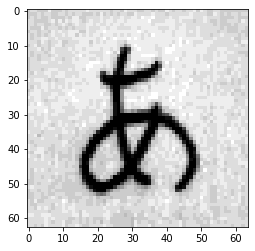

In [5]:
plt.imshow(df['bytes_array'][0], cmap=plt.cm.gray_r, interpolation='nearest')
plt.show()

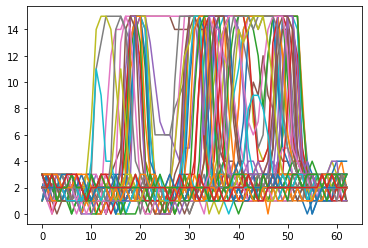

In [6]:
plt.plot(df['bytes_array'][0])
plt.show()



##### Method


In [7]:
def remove_noise(x):
    noiseless_matrix = []
    for row in x['bytes_array']:
        noiseless_matrix.append(np.array([0. if x < 6.0 else x for x in row], dtype="float32"))
    return np.array(noiseless_matrix, dtype='float32')

df['noiseless_bytes_array'] = df.apply(remove_noise, axis=1)

df.head()

,phonetic,hiragana,image_bytes,bytes_array,noiseless_bytes_array
0,A,あ,"b'2#3\x133#""""!""""""2#\x12""3""23\x122#""\x13\x123""3...","[[3.0, 2.0, 2.0, 3.0, 3.0, 3.0, 1.0, 3.0, 3.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
1,A,あ,"b'3334332""#3""2C""#2#""!3""2#""""""""""23C233CC33C33322...","[[3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 4.0, 3.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
2,A,あ,"b'32333333#22""3""2""#2""#""2#2""#33#3332233#233""22\...","[[3.0, 3.0, 3.0, 2.0, 3.0, 3.0, 3.0, 3.0, 3.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
3,A,あ,"b'C4B33332232#33##3""###3""2#3243333D3C433#2232$...","[[4.0, 3.0, 3.0, 4.0, 4.0, 2.0, 3.0, 3.0, 3.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
4,A,あ,"b'2223""2!""""""!""#""""""22""""\x12!""!!""#\x12""""23312#""""...","[[3.0, 2.0, 3.0, 2.0, 3.0, 2.0, 3.0, 3.0, 2.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."


##### Output

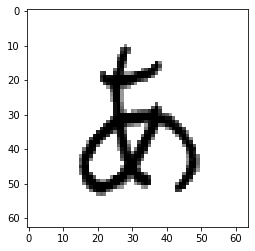

In [8]:
plt.imshow(df['noiseless_bytes_array'][0], cmap=plt.cm.gray_r, interpolation='nearest')
plt.show()

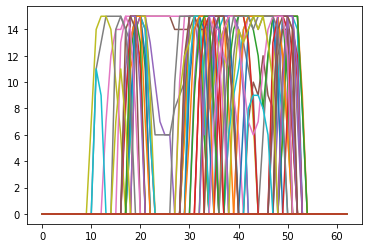

In [9]:
plt.plot(df['noiseless_bytes_array'][0])
plt.show()

## Vizualize Image

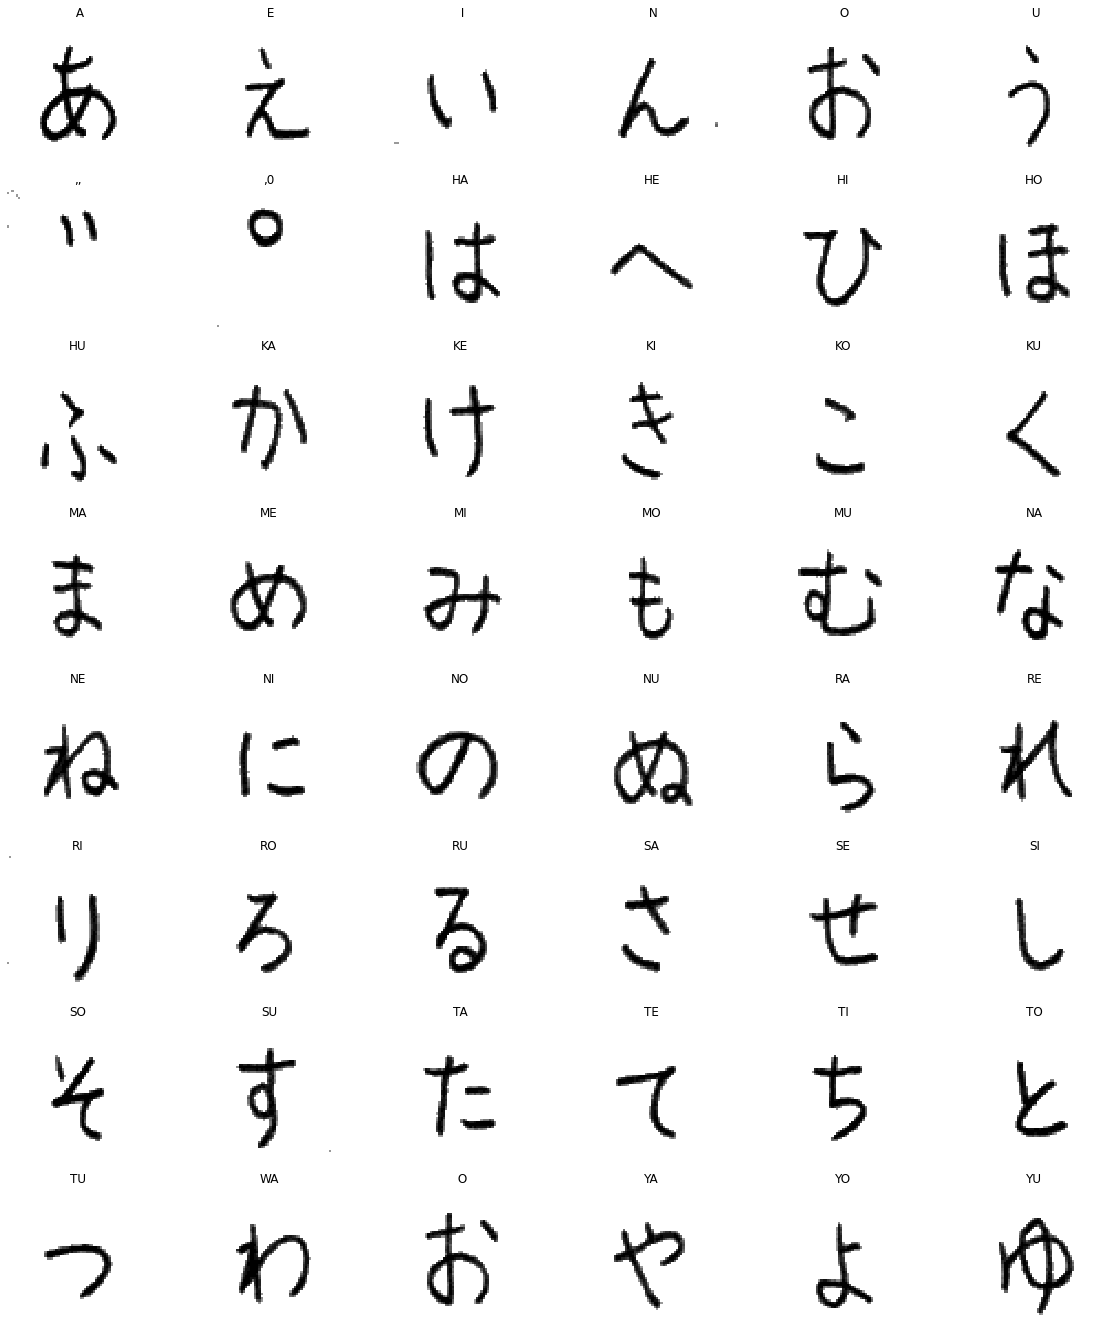

In [10]:
n_rows = 8
n_cols = 6
plt.rc('axes', unicode_minus=False)
_, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(20, 24))

size = len(HIRAGANA) / 2
hiraganas = list(HIRAGANA.values())

for index, value in enumerate(hiraganas):
    x = int(index / n_cols)
    y = index % n_cols
    ax = axes[x][y]
    phonetic, _, _, _, noiseless_bytes_array = df[df['hiragana'] == value].values[0]
    ax.imshow(noiseless_bytes_array, cmap=plt.cm.gray_r, interpolation='nearest')
    ax.set_title(phonetic)
    ax.axis('off')

plt.savefig('train_data_image.jpg')
plt.show()

## Prepare Images Data & Labels

#### Labels

In [11]:
labels = df['hiragana'].values
labels

array(['あ', 'あ', 'あ', ..., '゜', '゜', '゜'], dtype=object)

#### Training Dataset

In [12]:
images_dataset = df['noiseless_bytes_array'].values
images_dataset[0]

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

### Reshape Images Bytes Array from (HEIGHT, WIDTH) to (HEIGHT*WIDTH)

#### Input :

In [13]:
output_shape = WIDTH*HEIGHT
n_samples = df['noiseless_bytes_array'].values.size
target = (n_samples, output_shape)

print(f'Expected: {target}\nOuput: {np.shape(images_dataset[0])}\nEqual: {np.shape(images_dataset[0]) == target}')

Expected: (33600, 4032)
Ouput: (63, 64)
Equal: False


#### Method

In [14]:
reshape_matrix = lambda x: np.reshape(x['noiseless_bytes_array'], output_shape)

df['reshaped_bytes_array'] = df.apply(reshape_matrix, axis=1)

data = np.array(list(df['reshaped_bytes_array']), dtype='float32')
data

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

#### Output

In [15]:
print(f'Expected: {(target)}\nOuput: {np.shape(data)}\nEqual: {np.shape(data) == target}')

Expected: (33600, 4032)
Ouput: (33600, 4032)
Equal: True


## Machine Learning

### KNeighbors

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    data, labels, test_size=0.5, shuffle=True
)

In [ ]:
scores = []
max_neighbors = 15

for i in range(max_neighbors):
    knn = KNeighborsClassifier(n_neighbors=i+1)
    knn.fit(X_train, y_train)
    result=knn.predict(X_test)
    scores.append(accuracy_score(y_test,result))

In [ ]:
scores_distance = []
max_neighbors = 15

for i in range(max_neighbors):
    knn = KNeighborsClassifier(n_neighbors=i+1, weights='distance')
    knn.fit(X_train, y_train)
    result=knn.predict(X_test)
    scores_distance.append(accuracy_score(y_test,result))

In [ ]:
nb_knn = list(range(1, 16))
plt.plot(nb_knn, scores, label = "Classic weight")
plt.plot(nb_knn, scores_distance, label = "Distance weight")
plt.legend()
plt.show()

### Random Forest

In [ ]:
rdf=RandomForestClassifier(n_estimators=100)
rdf.fit(X_train,y_train)
result=rdf.predict(X_test)
print('Accuracy :',accuracy_score(y_test,result))
print(classification_report(y_test,result))

### GridSearch

In [ ]:
tuned_parameters = [
    {'kernel': ['rbf'], 'gamma': [1e-3, 1e-4], 'C': [1, 10, 100, 1000]},
    {'kernel': ['linear'], 'C': [1, 10, 100, 1000]},
    {'kernel': ['poly'], 'degree': [2, 3], 'C': [1, 10, 100, 1000]},
    {'kernel': ['sigmoid'], 'C': [1, 10, 100, 1000]}
]

scores = ["precision", "recall"]

for score in scores:
    print("# Tuning hyper-parameters for %s" % score)
    print()

    clf = GridSearchCV(SVC(), tuned_parameters, scoring="%s_macro" % score)
    clf.fit(X_train, y_train)

    print("Best parameters set found on development set:")
    print()
    print(clf.best_params_)
    print()
    print("Grid scores on development set:")
    print()
    means = clf.cv_results_["mean_test_score"]
    stds = clf.cv_results_["std_test_score"]
    for mean, std, params in zip(means, stds, clf.cv_results_["params"]):
        print("%0.3f (+/-%0.03f) for %r" % (mean, std * 2, params))
    print()

    print("Detailed classification report:")
    print()
    print("The model is trained on the full development set.")
    print("The scores are computed on the full evaluation set.")
    print()
    y_true, y_pred = y_test, clf.predict(X_test)
    print(classification_report(y_true, y_pred))
    print()

### Support vector machine

In [ ]:
clf = svm.SVC(gamma='scale',class_weight='balanced',C=100)

clf.fit(X_train,y_train)

result=clf.predict(X_test)

print('Accuracy :',accuracy_score(y_test,result))
print(classification_report(y_test,result))

### Export Model

In [ ]:
with open('hiragana_recognition.pkl', 'wb') as f:
    pickle.dump(clf, f)